# A Influência da Dimensão Espacial nos Valores Médios das Rendas Habitacionais: Uma Análise Econométrica Espacial das Freguesias da Região de Aveiro

### Quais os fatores espaciais que influenciam a variação dos valores médios das rendas dos alojamentos nas freguesias da região de Aveiro?

A variação dos valores das rendas nas freguesias da Região Aveiro não é aleatória, sendo influenciada por fatores espaciais como proximidade a centros urbanos, acessibilidade e dinâmica socioeconómica. A econometria permite analisar se há dependência espacial, ou seja, se os preços das rendas numa freguesia são influenciados pelos das freguesias vizinhas. Identificar esses padrões ajuda a compreender a formação dos preços, detetar clusters de rendas elevadas e fornecer informações relevantes para políticas habitacionais e planeamento urbano mais eficientes.

### Configuração do Ambiente e Importação de Bibliotecas

#### Importação de Bibliotecas

In [1]:
import os
import sys
import importlib
from pathlib import Path

import pandas as pd
import geopandas as gpd

import numpy as np



import matplotlib.pyplot as plt
import contextily as cx

import folium

In [2]:
print(gpd.options.io_engine)

None


In [3]:
from pyogrio import list_layers

#### Definição da diretoria de trabalho na diretoria raiz do projeto

In [4]:
from pathlib import Path

# Find the project root (assuming marker-based or script-relative path)
def find_project_root(marker="README.md"):
    current_dir = Path.cwd()
    while current_dir != current_dir.parent:  # Traverse up until root
        if (current_dir / marker).exists():
            return current_dir
        current_dir = current_dir.parent
    raise FileNotFoundError(f"Marker '{marker}' not found in any parent directory.")

project_root = find_project_root()
sys.path.append(str(project_root))

# Or use a relative path: project_root = Path(__file__).resolve().parent.parent
os.chdir(project_root)
print(f"Working directory set to: {project_root}")

Working directory set to: C:\Users\wpego\anaconda3\projETE2425-main


#### Inclusão de biblioteca própria aos caminhos das bibliotecas

In [5]:
module_path = os.path.abspath(os.path.join(r'.\src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
module_path

'C:\\Users\\wpego\\anaconda3\\projETE2425-main\\src'

In [7]:
import utils.utils_ete2425

### Preparação e Estruturação dos Dados Geoespaciais

Prepararam-se os dados geoespaciais que servirão como base para associar as freguesias aos valores da variável em estudo. Através do BGRI (Base Geográfica de Referenciação da Informação), obtêm-se unidades espaciais detalhadas da Região de Aveiro, delimitando a área de análise. Por outro lado, o CAOP (Carta Administrativa Oficial de Portugal) fornece os limites administrativos, sendo as freguesias a unidade territorial de interesse.

Para garantir a compatibilidade e facilitar a análise espacial, os dados converteram-se para o sistema de coordenadas global WGS84 (EPSG:4326). Esta transformação permite uma melhor integração dos dados em análises espaciais, mapas interativos e modelação econométrica espacial, assegurando que todas as camadas de informação estejam alinhadas no mesmo referencial.

#### Carregamento de Dados Geoespaciais

BGRI: https://mapas.ine.pt/download/index2021

REGIAO DE AVEIRO [BGRI21_16D.gpkg](https://mapas.ine.pt/download/filesGPG/2021/nuts3/BGRI21_16D.zip)

NUTS3: 191 região de aveiro.
link [CAOP2024](https://www.dgterritorio.gov.pt/sites/default/files/ficheiros-cartografia/Areas_Freg_Mun_Dist_Pais_CAOP2024.zip)


In [8]:
shape_REGIAO_AVEIRO = gpd.read_file(r'.\data\input' + r'\HW01\BGRI21_16D.gpkg', layer = 'BGRI21_16D' )

#### Visualização e Transformação dos Dados

A visualização dos dados geográficos permite validar se as freguesias da região de Aveiro estão corretamente representadas.

<Axes: >

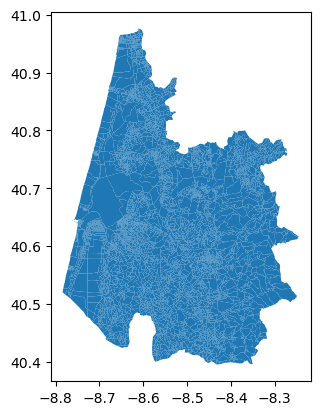

In [9]:
shape_REG_AVEIRO_WGS84 = shape_REGIAO_AVEIRO.to_crs(epsg=4326)
shape_REG_AVEIRO_WGS84.plot()

### Processamento e Análise dos Dados Espaciais e das Rendas Habitacionais

#### Carregamento e Estruturação dos Dados das Rendas Habitacionais

Optou-se pelo seguinte indicador disponibilizado pelo INE (Instituto Nacional de Estatística): **Valor médio mensal das rendas dos alojamentos familiares clássicos arrendados (€) por Localização geográfica à data dos Censos [2021] (NUTS - 2013). Decenal – INE, Recenseamento da população e habitação – Censos 2021**. Nota-se que este indicador representa uma visão geral do mercado de arrendamento, agregando transações realizadas em diferentes momentos no tempo. Como está associado à operação censitária, apresenta uma cobertura abrangente, incluindo todas as freguesias do país e unidades espaciais de fins estatísticos, como as subsecções.

A seleção dos dados deste indicador incidiu exclusivamente sobre a Região de Aveiro, garantindo que a análise concentra-se apenas no território em estudo.

In [10]:
db_excel_ine_rendaHab = pd.read_excel(r'.\data\input\HW01\HW01.xlsx',
                                       skiprows=9,
                                       skipfooter=5, header=None,
                                       dtype='str'
                                       )
db_excel_ine_rendaHab.rename(columns={0:"Designacao", 1:"GeoCod", 2:"ValMed_RendaMen"}, inplace=True)

In [11]:
#visulizando as duas primeiras observações (0,1) e as duas ultimas (-2,-1)
db_excel_ine_rendaHab.iloc[[0,1,-2,-1]]

,Designacao,GeoCod,ValMed_RendaMen
0,Região de Aveiro,16D,321.38
1,Águeda,0101,278.43
84,União das freguesias de Ponte de Vagos e Santa...,011813,294.26
85,União das freguesias de Vagos e Santo António,011814,315.68


In [12]:
db_excel_ine_rendaHab['LEVEL'] = db_excel_ine_rendaHab['GeoCod'].str.len()

In [13]:
db_excel_ine_rendaHab.head(4)

,Designacao,GeoCod,ValMed_RendaMen,LEVEL
0,Região de Aveiro,16D,321.38,3
1,Águeda,0101,278.43,4
2,Aguada de Cima,010103,256.49,6
3,Fermentelos,010109,277,6


In [14]:
#selecionando apenas as freguesias
db_excel_ine_rendaHab_freg = db_excel_ine_rendaHab[db_excel_ine_rendaHab['LEVEL'] == 6]
db_excel_ine_rendaHab_freg.iloc[0:5]

,Designacao,GeoCod,ValMed_RendaMen,LEVEL
2,Aguada de Cima,010103,256.49,6
3,Fermentelos,010109,277,6
4,Macinhata do Vouga,010112,262.7,6
5,União das freguesias de Águeda e Borralha,010121,293.49,6
6,União das freguesias de Barrô e Aguada de Baixo,010122,257.15,6


#### Construção de Polígonos por freguesia para Análise Espacial

In [15]:
agg_columns = shape_REG_AVEIRO_WGS84.columns[13:45].tolist()

In [16]:
agg_dict = {col: 'sum' for col in agg_columns}

<Axes: >

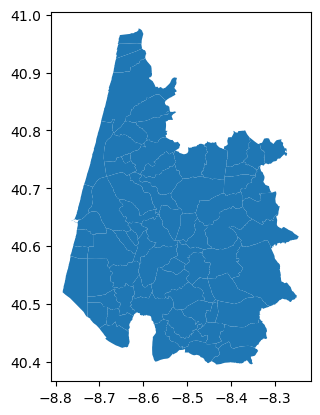

In [17]:
# Criar uma representação geométrica do municipio (polígono único)
# Permite-nos ter uma representação dos limites da área de estudo
# Atenção que mantém o mesmo referencial geográfico dos dados originais

shape_REG_Aveiro = shape_REG_AVEIRO_WGS84.dissolve(by='DTMNFR21', aggfunc=agg_dict)#agrega a area para as freguesias
shape_REG_Aveiro.plot()

**Notas:**

Optámos por representar as freguesias através de **polígonos georreferenciados**, pois esta abordagem permite uma visualização clara da distribuição espacial das rendas da habitação. O uso de shapefiles (ficheiros extraídos do INE) facilita a sobreposição com dados estatísticos e a criação de matrizes de vizinhança.

Este tipo de representação, muito comum em análises econométricas espaciais,ajuda a perceber se freguesias próximas têm valores parecidos ou se há grandes diferenças entre vizinhos. Também nos permite calcular as distâncias entre freguesias e ver se os preços das rendas influenciam-se uns aos outros, fatores fundamentais para avaliar a dependência espacial e a autocorrelação dos dados.

#### Reprojeção e Sobreposição com Mapas de Base

In [18]:
# Projeção geográfica do sistema de referenciação fornecido na BGRI2021 (EPSG:3763) para o sistema de referenciação
# utilizado na biblioteca "contextily" (EPSG:3857)
# A biblioteca "contextily" permite a sobreposição de mapas base (imagens de satélite, mapas de ruas, etc) sobre
# os nossos mapas / representações geométricas das nossas unidades de análise
shape_REG_Aveiro_WGS84_reprojetct = shape_REGIAO_AVEIRO.to_crs(epsg=3857)

In [ ]:
# Adição de um mapa de fundo ao nosso mapa de subsecções estatísticas do Porto
# Neste caso, associamos um mapa obtido no serviço OpenStreetMaps https://www.openstreetmap.org/

ax = shape_REG_Aveiro_WGS84_reprojetct.plot(figsize=(10, 10), alpha=0.2, edgecolor="k")
cx.add_basemap(ax)

#### Integração das Rendas Habitacionais com os Dados Espaciais

In [ ]:
db_excel_ine_rendaHab_freg = db_excel_ine_rendaHab_freg.copy()
db_excel_ine_rendaHab_freg.rename(columns={"GeoCod":"DTMNFR21"}, inplace=True)
db_excel_ine_rendaHab_freg['ValMed_RendaMen'] = db_excel_ine_rendaHab_freg['ValMed_RendaMen'].astype(float)

In [ ]:
shape_REG_Aveiro_rendaHab = shape_REG_Aveiro.merge(db_excel_ine_rendaHab_freg, left_on = 'DTMNFR21', right_on = 'DTMNFR21', how = 'left')

#### Visualização da Distribuição Espacial das Rendas

In [ ]:
figura, ax = plt.subplots(1, figsize=(8, 9))
shape_REG_Aveiro_rendaHab.plot(ax=ax, column='ValMed_RendaMen',
                               legend=True)
ax.set_axis_off()
ax.set_title('Valor médio mensal das rendas dos alojamentos familiares clássicos arrendados (€) (2021)')
plt.axis('equal')
plt.show()

**Análise:**

O mapa apresenta a distribuição espacial dos valores médios das rendas dos alojamentos familiares arrendados na região de Aveiro à data de 2021. A escala de cores *indica* uma variação significativa nos preços, com valores mais baixos representados por tons azulados e mais elevados por tons amarelados.

Observa-se que as freguesias com rendas mais elevadas estão concentradas na faixa ocidental da região, especialmente próximas ao litoral, onde há uma maior atratividade económica e turística. Em contraste, as freguesias do interior apresentam rendas mais reduzidas, sugerindo menor pressão da procura habitacional.

Uma exceção a este padrão verifica-se na área que inclui S. Jacinto e Torreira, onde as rendas médias são relativamente baixas, apesar da proximidade ao litoral. Esta discrepância pode estar associada a fatores como acessibilidade limitada, menor desenvolvimento urbano ou um mercado imobiliário menos dinâmico em comparação com outras zonas costeiras da região.

A distribuição espacial sugere a presença de dependência espacial, uma característica relevante para a análise econométrica. Freguesias adjacentes tendem a exibir valores semelhantes e próximos entre si, o que pode indicar a influência de fatores regionais como acessibilidade, oferta imobiliária e a dinâmica do mercado local.

#### Análise da Distribuição das Rendas e Classificação dos Dados

In [ ]:
# https://pysal.org/mapclassify/api.html
# pysal.viz »» mapclassify
import mapclassify as mc

import seaborn as sns

In [ ]:
shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].describe().round(1)


A visualização dos padrões geográficos das variáveis constitui um elemento chave na análise exploratória dos dados espacias.
No entanto, a visualização requer a configuração de paletes de cor para descrever as características marcantes dos dados. Importa assim perceber a distribuição dos dados e fornecer uma palete de cores que nos descreva as propriedades mais marcantes dessa distribuição.

Importa assim conjugar a exploração gráfica da distribuição dos dados - para a qual recorremos à livraria mapclassify e seaborn - bem como a sua visualização geográfica.

In [ ]:
# Intervalos iguais

classi = mc.EqualInterval(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], k=7)
classi

##### Quantiles

In [ ]:
classi_quant = mc.Quantiles(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], k=6)
classi_quant

In [ ]:
classi_quant.bins

In [ ]:
# Código padrão - usa a livraria seaborn (extende a matplotlib )
# https://seaborn.pydata.org/tutorial.html
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], fill=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi_quant.bins:
    plt.axvline(cut, color='red', linewidth=0.75)

**Análise:**

O gráfico anterior é um gráfico de densidade KDE (Kernel Density Estimation) que representa a distribuição dos valores médios das rendas habitacionais nas freguesias da Região de Aveiro.

A forma do gráfico sugere que os valores das rendas seguem uma distribuição aproximadamente normal, com uma leve assimetria à direita. Maior parte dos valores das rendas está concentrada entre 230 € e 360 €, aproximadamente, com um pico próximo dos 280 €, que representa a moda da distribuição. É de notar, ainda, que existem algumas freguesias com rendas superiores a 400 €, podendo indicar a presença de valores atípicos (outliers) em zonas específicas.

As linhas vermelhas representam os intervalos definidos pelo método dos quantis, dividindo os dados em 6 classes de igual frequência. É possível observar que maior parte das freguesias está nos quantis centrais, reforçando a ideia de que os preços são relativamente homogéneos na região de Aveiro, embora haja alguma variação. A presença de quantis próximos entre si no centro da distribuição indica uma alta concentração de valores de rendas próximos, enquanto os quantis mais distantes nas extremidades sugerem que existem algumas freguesias com rendas significativamente mais baixas ou mais altas.

O gráfico confirma a existência de variabilidade espacial nos preços das rendas na região em estudo, justificando a necessidade de uma análise econométrica espacial de forma a entender melhor os fatores que influenciam essa variação.

#### Visualização da Distribuição Espacial das Rendas Habitacionais

In [ ]:
#NOTAs:
# note-se que agora temos de definir os argumentos column, scheme e cmap
# o argumento «cmap» pode ser configurado seguindo esquemas predefinidos:
# https://matplotlib.org/stable/gallery/color/colormap_reference.html


#Usar a matplotlib para visualizar vários dados
figura, ax = plt.subplots(figsize = (10,10) )
ax.set_aspect('equal')
shape_REG_Aveiro_rendaHab.plot(ax=ax, zorder=2,
                             color='grey',
                             edgecolor='black', linewidth=2,
                            alpha = 0.3)

shape_REG_Aveiro_rendaHab.plot(ax=ax,zorder=1,
                      # marker="s",
                      column='ValMed_RendaMen',
                      scheme='Quantiles',
                      # k=7,
                      cmap=plt.cm.Reds,
                      linewidth=0 )

**Análise:**

Este mapa apresenta uma versão macro e simplificada da distribuição das rendas médias apresentadas no último mapa, com menos categorias de classificação. Embora contenha menos detalhe, continua a ser possível perceber a tendência geral de rendas mais elevadas nas zonas costeiras, e mais baixas no interior. As relações de vizinhança visíveis sugerem uma dependência espacial, com exceção das freguesias de S. Jacinto e Torreira justificadas anteriormente.

#### Classificação das Rendas Habitacionais

Diferentes métodos estatísticos de classificação são aplicados aos valores das rendas. O **desvio padrão** separa os dados com base na média e no desvio padrão, o **boxplot** segmenta os dados conforme quartis, considerando a distribuição da variável, e o **Fisher Jenks** otimiza a separação de classes minimizando a variância dentro de cada grupo, auxiliando na segmentação espacial dos valores das rendas e na identificação de padrões estruturais.

In [ ]:
# Desvio padrão médio
classi = mc.StdMean(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'])
classi

In [ ]:
# Baseado na caixa de bigodes
classi = mc.BoxPlot(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'])
classi

In [ ]:
# Fisher Jenks

classi = mc.FisherJenks(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'])
classi

#### Criação de Mapa Interativo com Folium

In [ ]:
import folium
import geopandas as gpd

# Ensure CRS is set to WGS84 (EPSG:4326) for compatibility with Folium
shape_REG_Aveiro_rendaHab_folium = shape_REG_Aveiro_rendaHab.to_crs(epsg=4326)

shape_REG_Aveiro_rendaHab_folium["ValMed_RendaMen_rounded"] = shape_REG_Aveiro_rendaHab_folium["ValMed_RendaMen"].apply(lambda x: f"{x:.0f} €")
#shape_REG_Aveiro_rendaHab_folium["DivAct_PT_rounded"] = shape_REG_Aveiro_rendaHab_folium["DivAct_PT"].apply(lambda x: f"{x:.2f}")

# Compute map center based on centroids
map_center = [
    shape_REG_Aveiro_rendaHab_folium.geometry.centroid.y.mean(),
    shape_REG_Aveiro_rendaHab_folium.geometry.centroid.x.mean()
]



# Create Folium map
m = folium.Map(
    location=map_center,
    tiles="OpenStreetMap",
    zoom_start=13,
    control_scale=False
)

# Add Choropleth layer for visualization
folium.Choropleth(
    geo_data=shape_REG_Aveiro_rendaHab_folium,
    data=shape_REG_Aveiro_rendaHab_folium,
    columns=["DTMNFR21", "ValMed_RendaMen"],
    key_on="feature.properties.DTMNFR21",
    fill_color='Reds',
    fill_opacity=0.6,
    line_opacity=0.5,
    linewidth=0.5,
    legend_name="Valor Medio Renda Mensal"
).add_to(m)

# Function to create HTML popups dynamically
def create_popup(properties):
    popup_html = "<b>Feature Info:</b><br>"
    popup_html += "<br>".join([f"{key}: {value}" for key, value in properties.items()])
    return popup_html

# Define a style function for polygon boundaries
def style_function(feature):
    return {
        'color': 'black',       # Boundary line color
        'weight': 2,            # Line thickness (higher values = thicker borders)
        'fill_opacity': 0.6,     # Adjust fill transparency
        'fill_color': 'Reds'      # Optional: Override Choropleth fill color
    }
# Add GeoJson with popups
folium.GeoJson(
    shape_REG_Aveiro_rendaHab_folium,
    name="BGRI Polygons",
    style_function=style_function,  # Apply custom boundary styles
    tooltip=folium.GeoJsonTooltip(
        fields=["Designacao","DTMNFR21", "ValMed_RendaMen_rounded"],
        aliases=["Freguesia","BGRI Code:", "Renda Média Mensal (€):"]
    ),
    popup=folium.GeoJsonPopup(
        fields=["Designacao","DTMNFR21", "ValMed_RendaMen_rounded"],
        aliases=["Freguesia","BGRI Code:", "Renda Média Mensal (€):"]
    )
).add_to(m)

# Save and display
m

#### Construção da Matriz de Pesos Espaciais

A matriz de pesos é essencial para modelar a dependência espacial. Definem-se vizinhanças com base no compartilhamento de fronteiras ou vértices, permitindo avaliar se as rendas numa freguesia estão correlacionadas com as das freguesias vizinhas.

In [ ]:
import scipy

In [ ]:
scipy.__version__

In [ ]:
from pysal.lib import weights


# # https://pysal.org/libpysal/api.html
# from libpysal.weights.contiguity import Queen

# from libpysal.cg import voronoi_frames

In [ ]:
# Contiguidade Queen

w_rook_shape_REG_Aveiro_rendaHab = weights.contiguity.Queen.from_dataframe(shape_REG_Aveiro_rendaHab)

In [ ]:
shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].describe()

In [ ]:
shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].isna().sum()

**Nota:** Não há dados em falta, portanto não é necessário a imputação de dados.

### Associação (autocorrelação) espacial

A associação espacial emerge nos dados quando é possível observar correlações entre observações «próximas». Na análise univariada, pode-se calcular o "Índice de Moran - Índice Global de Associação Espacial" bem como a sua "variante" local: o "Índice Local de Associação Espacial" LISA (na sigla inglesa).

#### Associação espacial - Global

O **índice de Moran** mede a autocorrelação espacial, ou seja, verifica se há uma relação estatística entre os valores das rendas e os valores das freguesias vizinhas. Se os valores próximos forem muito semelhantes, existe autocorrelação espacial positiva, caso sejam muito diferentes, há autocorrelação espacial negativa.

Moran’s I é definido por:
$$
I = \frac{N}{W}\frac{\sum_{i} \sum_{j} w_{ij} (x_i - \bar{x})(x_j - \bar{x})}{\sum_{i} (x_i - \bar{x})^2}
$$
onde:
- $( N )$ é o número total de observações no espaço
- $( W )$ é a soma de todos os pesos $( w_{ij} )$
- $( x_i )$ é o valor observado na localização $( i )$
- $( \bar{x} )$ é a média de todas as observações
- $( w_{ij} )$ é o peso espacial entre locais $( i )$ e $( j )$


**Interpretação de Moran's I:**
- $I > 0$ indica autocorrelação espacial positiva (valores similares próximos).
- $I < 0$ indica autocorrelação espacial negativa (valores dissimilares próximos).
- $I \approx 0$ indica ausência de autocorrelação espacial.



In [ ]:
# Calcular o "spatial lag" (desfasamento espacial)

precoM2_lag = weights.lag_spatial(w_rook_shape_REG_Aveiro_rendaHab, shape_REG_Aveiro_rendaHab['ValMed_RendaMen'])
shape_REG_Aveiro_rendaHab["ValMed_RendaMen_lag"] = precoM2_lag

In [ ]:
# "Normalizar" (cálculo de z-scores) as variáveis (original e desfasada)
shape_REG_Aveiro_rendaHab['ValMed_RendaMen_std'] = ( shape_REG_Aveiro_rendaHab['ValMed_RendaMen'] - shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].mean() )\
                    / shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].std()
shape_REG_Aveiro_rendaHab['ValMed_RendaMen_lag_std'] = ( shape_REG_Aveiro_rendaHab['ValMed_RendaMen_lag'] - shape_REG_Aveiro_rendaHab['ValMed_RendaMen_lag'].mean() )\
                    / shape_REG_Aveiro_rendaHab['ValMed_RendaMen_lag'].std()

In [ ]:
# Moran Plot
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='ValMed_RendaMen_std', y='ValMed_RendaMen_lag_std',
                ci=None, data=shape_REG_Aveiro_rendaHab, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot')
plt.show()

**Análise:**

O gráfico acima apresentado mostra a relação entre os valores normalizados da variável de interesse (renda habitacional média) e os valores médios vizinhos espaciais, sendo que a reta vermelha indica a tendência da relação espacial.

O coeficiente positivo da reta sugere uma autocorrelação espacial positiva fraca, significando que há uma leve tendência de locais com valores semelhantes de renda habitacional estarem próximos uns dos outros. No entanto, a dispersão dos pontos sugere que essa autocorrelação pode não ser muito forte.

In [ ]:
# Gerar dados espaciais sintéticos
def gerar_dados_grelha(linhas=10, colunas=10, random_state=42):
    np.random.seed(random_state)
    x, y = np.meshgrid(range(colunas), range(linhas))
    pontos = np.column_stack([x.ravel(), y.ravel()])
    valores = np.random.rand(linhas * colunas)
    return pontos, valores

# Gerar dados sintéticos
pontos, valores = gerar_dados_grelha()


In [ ]:


from libpysal.weights import lat2W

# Criar matriz de pesos
w = lat2W(int(np.sqrt(len(pontos))), int(np.sqrt(len(pontos))))
matriz_pesos = np.array(w.full()[0])

In [ ]:
# Função para calcular Moran's I
def morans_I(valores, matriz_pesos):
    N = len(valores)
    W = matriz_pesos.sum()
    x_barra = np.mean(valores)
    desvios = valores - x_barra
    num = sum(matriz_pesos[i, j] * desvios[i] * desvios[j] for i in range(N) for j in range(N))
    denom = sum(desvios ** 2)
    return (N / W) * (num / denom)

In [ ]:
moran_val = morans_I(valores, matriz_pesos)

In [ ]:
moran_val

In [ ]:
np.array(w_rook_shape_REG_Aveiro_rendaHab.full()[0])



In [ ]:
moran_val_cs = morans_I(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], w_rook_shape_REG_Aveiro_rendaHab.full()[0] )

moran_val_cs

#### Inferência

Os testes de permutação avaliam a significância estatística dos índices espaciais ao compará-los a distribuições empíricas geradas a partir de permutações aleatórias dos dados.

**Hipóteses dos Testes de Permutação - Moran I**
- **Hipótese nula ($H_0$)**: Não há autocorrelação espacial, os valores estão distribuídos aleatoriamente.
- **Hipótese alternativa ($H_1$)**: Existe autocorrelação espacial significativa.

#### Teste de Permutação para Significância Estatística

O teste de permutação avalia a significância da autocorrelação espacial. Ao gerar distribuições empíricas aleatórias, pode-se comparar o Moran's I observado com valores esperados sob a hipótese nula (ausência de padrão espacial). O *p-value* indica se a autocorrelação detetada é estatísticamente significante.

In [ ]:
# Teste de permutação para Moran's I
def permutacao_morans_I(valores, matriz_pesos, num_permutacoes=999):
    I_obs = morans_I(valores, matriz_pesos)
    permutados = np.zeros(num_permutacoes)
    for i in range(num_permutacoes):
        valores_perm = np.random.permutation(valores)
        permutados[i] = morans_I(valores_perm, matriz_pesos)
    p_valor = np.mean(permutados >= I_obs)
    return I_obs, permutados, p_valor

In [ ]:
#I_obs, I_permutados_obs, I_permutados_pvalue = permutacao_morans_I(valores, matriz_pesos, 999)
#I_obs, I_permutados_pvalue
I_obs, I_permutados_obs, I_permutados_pvalue = permutacao_morans_I(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'],
                                                                   w_rook_shape_REG_Aveiro_rendaHab.full()[0] , 999)
I_obs, I_permutados_pvalue


**Análise:**

O valor do **Moran's I** observado (I_obs = 0.3170) é positivo, indicando a presença de autocorrelação espacial. Isso significa que locais com rendas habitacionais semelhantes tendem a estar próximos. Além disso, o valor de 0.3170 sugere uma autocorrelação moderada, pois está consideravelmente distante de zero.

Por outro lado, o ***p-value*** (I_permutados_pvalue = 0.0) é extremamente baixo, o que indica forte evidência estatística contra a hipótese nula de ausência de autocorrelação espacial significativa. Em outras palavras, a estrutura espacial observada nos dados não pode ser explicada por acaso, reforçando a existência de um padrão espacial significativo na distribuição das rendas habitacionais.

In [ ]:
# Visualizar a distribuição empírica
plt.hist(I_permutados_obs, bins=30, alpha=0.7, color='blue')
plt.axvline(moran_val_cs, color='red', linestyle='dashed', linewidth=2)
plt.title("Distribuição Empírica do Teste de Permutação para Moran's I")
plt.xlabel("Valores de Moran's I Permutados")
plt.ylabel("Frequência")
plt.show()

**Análise:**

O histograma mostra a distribuição dos valores de Moran's I gerados por permutação aleatória, sendo que a linha vermelha representa o Moran's I observado nos dados reais.

Como dito anteriormente, como o valor de Moran's I observado está fora da distribuição, a autocorrelação espacial é estatisticamente significativa.

In [ ]:
# Este código não está otimizado para grandes conjuntos de dados pelo que pode demorar algum tempo a executar

# I_permutados_cs_Iobs,I_permutados_cs, I_permutados_pvalue  = permutacao_morans_I(shape_BGRI21_Porto_CircEUlar['HousingPrice_Imputation'], w_rook_shape_BGRI21_Porto_CircEUlar.full()[0], 999)
# I_permutados_cs_Iobs,I_permutados_pvalue

##### Usando a biblioteca PySAL

In [ ]:
# from pysal.explore import esda
from esda.moran import Moran
from esda.moran import Moran_Local

# https://splot.readthedocs.io/en/latest/api.html
# pysal.viz »» splot [splot.esda] (tem métodos para esda e outras componentes - ver api)
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from splot.esda import plot_moran


In [ ]:
moran_REG_Aveiro_rendaHab_WRook = Moran(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], w_rook_shape_REG_Aveiro_rendaHab)
moran_REG_Aveiro_rendaHab_WRook.I, moran_REG_Aveiro_rendaHab_WRook.p_sim

#### Associação espacial - Local

LISA mede a autocorrelação local e é definido por:
$$
I_i = \frac{(x_i - \bar{x})}{S^2} \sum_j w_{ij} (x_j - \bar{x})
$$

onde:
- $I_i$ é o valor de Moran's I local para a observação $i$.
- $S^2$ é a variância da variável espacial.
- $w_{ij}$ é o peso espacial entre a observação $i$ e seus vizinhos $j$.


**Interpretação de Moran's I:**
- $I > 0$ indica autocorrelação espacial positiva (valores similares próximos).
- $I < 0$ indica autocorrelação espacial negativa (valores dissimilares próximos).
- $I \approx 0$ indica ausência de autocorrelação espacial.

Cada observação possui um valor LISA próprio, permitindo analisar padrões espaciais locais.


Interpretar os valores LISA:
   - **Alto-Alto (AA)**: valores elevados cercados por valores elevados.
   - **Baixo-Baixo (BB)**: valores baixos cercados por valores baixos.
   - **Alto-Baixo (AB)**: valores altos cercados por valores baixos.
   - **Baixo-Alto (BA)**: valores baixos cercados por valores altos.

In [ ]:
# Função para calcular LISA
def lisa_local(valores, matriz_pesos):
    n = len(valores)
    media_valores = np.mean(valores)
    desvios = valores - media_valores
    W_soma = matriz_pesos.sum(axis=1)
    lisa_I = np.array([(n / W_soma[i]) * (desvios[i] * np.sum(matriz_pesos[i, :] * desvios)) for i in range(n)])
    return lisa_I

In [ ]:
lisa_valores = lisa_local(valores, matriz_pesos)

#### Inferência

Os testes de permutação avaliam a significância estatística dos índices espaciais ao compará-los a distribuições empíricas geradas a partir de permutações aleatórias dos dados.

**Hipóteses dos Testes de Permutação - LISA**
- **Hipótese nula ($H_0$)**: O valor observado na localização $i$ não tem correlação espacial com seus vizinhos.
- **Hipótese alternativa ($H_1$)**: O valor na localização $i$ está correlacionado espacialmente com os vizinhos.

In [ ]:
def permutacao_lisa(valores, matriz_pesos, num_permutacoes=999):
    lisa_obs = lisa_local(valores, matriz_pesos)
    N = len(valores)
    permutados = np.zeros((num_permutacoes, N))
    for p in range(num_permutacoes):
        valores_perm = np.random.permutation(valores)
        permutados[p] = lisa_local(valores_perm, matriz_pesos)
    p_valores = np.mean(np.abs(permutados) >= np.abs(lisa_obs), axis=0)
    return lisa_obs, p_valores

##### Usando a biblioteca PySAL

In [ ]:
# calculate Moran_Local and plot
moranLocal_REG_Aveiro_rendaHab_WRook = Moran_Local(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], w_rook_shape_REG_Aveiro_rendaHab)

In [ ]:
lisa_cluster(moranLocal_REG_Aveiro_rendaHab_WRook, shape_REG_Aveiro_rendaHab, p=0.05, figsize = (8,9))
plt.show()

O mapa apresenta a análise LISA das rendas habitacionais, que torna possível identificar clusters espaciais relevantes para a análise exploratória dos dados.

A distribuição espacial das rendas sugere que existe desigualdade territorial, com áreas valorizadas próximas entre si e zonas com rendas de valores mais baixos, a saber:

*   AA (HH, vermelho): Freguesias com rendas elevadas rodeadas por outras igualmente altas. Esta concentração está ao centro da região, associada a melhores infraestruturas, serviços e à proximidade ao litoral.
*   BB (LL, azul escuro): Áreas com rendas baixas cercadas por outras também baixas, localizadas no interior. Este padrão reflete menor procura imobiliária e menor dinamismo económico.
*   AB (HL, laranja): Refere-se a freguesias com rendas elevadas, rodeadas por áreas com rendas mais baixas. Exemplos incluem Águeda e Albergaria-a-Velha, que são influenciadas pela existência de zonas industriais, que consequentemente, tem impacto na valorização imobiliária dessas freguesias.
*   BA (LH, azul escuro): Existe apenas uma freguesia na região de Aveiro nesta categoria. Apresenta-se com rendas baixas, cercada por áreas de rendas altas, e normalmente representa zonas de transição ou de crescimento.
*   ns (Não significativo, cinzento): Regiões sem padrão estatisticamente significativo.

In [ ]:
figura, ax = moran_scatterplot(moranLocal_REG_Aveiro_rendaHab_WRook, p=0.05)
ax.set_xlabel('HabitacoesRendaMensal')
ax.set_ylabel('Spatial Lag of HabitacoesRendaMensal')
plt.show()

Alinhado com a análise LISA, conseguimos também perceber através deste scatterplot as aglomerações de freguesias com valores semelhantes.

No **quadrante superior direito (AA)** estão representadas as unidades com valores mais altos e rodeadas por outras com valores parecidos. Enquanto que no **quadrante oposto (BB)**, temos um cluster de freguesias com valores baixos de renda vizinhos de outras com valores semelhantes.

Os outliers positivos presentes no **quadrante inferior direito (AB)** tem valores altos cercados por valores baixos, destacando-se da maioria das áreas ao redor.

O restante, que compõe a maioria da região, está distribuído de forma mais homogénea, sem uma clara tendência para valores altos ou baixos.

# Conclusão

A análise econométrica espacial das rendas habitacionais na região de Aveiro revela padrões de desigualdade espacial que têm implicações significativas no contexto económico e imobiliário. As áreas centrais, com rendas mais elevadas, estão fortemente associadas a uma melhor qualidade das infraestruturas, impulsionada pela procura e pelo dinamismo económico dessas zonas. Esse padrão evidencia uma concentração de recursos e oportunidades, que favorece as regiões mais próximas dos centros urbanos.

Por outro lado, as áreas mais periféricas, com rendas mais baixas, têm menor procura imobiliária e refletem um mercado mais estagnado, associado a uma menor atratividade para investimentos e desenvolvimento económico.

As zonas industriais, identificadas na categoria AB, acabam por ser uma exceção à regra e ilustram como o desenvolvimento económico local pode impactar os valores das rendas, criando áreas de transição onde a valorização imobiliária é mais lenta, mas com potencial de crescimento futuro. Isso pode ter implicações sociais, pois pode gerar uma mudança na dinâmica das populações, com a entrada de novos residentes e empresas.

Esses resultados destacam a necessidade de políticas públicas que promovem um desenvolvimento mais equilibrado de forma a minimizar as desigualdades no mercado imobiliário e favoreça a inclusão social e económica.

 O trabalho aqui apresentado foi realizado por:
- Ana Maria Rosca (108820);
- Filipa Santos (77632);
- Willian Pegorin (122970).